# For this predictive modeling task, bike share data is used from [dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) to predict hourly Bike Share Count "cnt"

## Import required Libraries

In [63]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
import warnings

def plot_correlation_heatmap(df, categorical_binary_cols=[], rounding=2, fig_width=10, fig_height=10, title="Correlation Matrix", title_size=16):
  """
  Plots a correlation heatmap for numerical features in a DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.
      categorical_binary_cols (list, optional): List of column names to exclude (considered binary&categorical). Defaults to [].
      rounding (int, optional): Number of decimal places to round the correlation values. Defaults to 2.
      fig_width (int, optional): Width of the Matplotlib figure. Defaults to 18.
      fig_height (int, optional): Height of the Matplotlib figure. Defaults to 15.
      title (str, optional): Title for the heatmap plot. Defaults to "Correlation Matrix".
      title_size (int, optional): Font size for the heatmap title. Defaults to 16.
  """

  
  numerical_cols = [col for col in df.columns if col not in categorical_binary_cols]
  corr = df[numerical_cols].corr().round(rounding)
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  f, ax = plt.subplots(figsize=(fig_width, fig_height))
  cmap = sns.diverging_palette(10, 220, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
  plt.title(title, fontsize=title_size)
  plt.show()

## Fetching the dataset 

In [64]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = pd.DataFrame(bike_sharing.data.features)
y = pd.DataFrame(bike_sharing.data.targets)
  
# variable information 
print(bike_sharing.variables) 

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

In [65]:
data = pd.concat([X, y], axis=1)
data

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


In [66]:
data['dteday'] = pd.to_datetime(data['dteday'])

# Convert 'hr' to timedelta format (represents hours)
data['hr_timedelta'] = pd.to_timedelta(data['hr'], unit='h')

# Combine 'dteday' with 'hr_timedelta' to get the datetime format
data['Datetime'] = data['dteday'] + data['hr_timedelta']
data.drop(columns=['dteday', 'hr_timedelta'], inplace=True)
data.set_index('Datetime', inplace=True)
data

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
Datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
2012-12-31 20:00:00,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
2012-12-31 21:00:00,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90


## Exploratory Data Analysis

In [67]:
data.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


C:\Users\Dell\AppData\Local\Temp\ipykernel_8720\2331994480.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


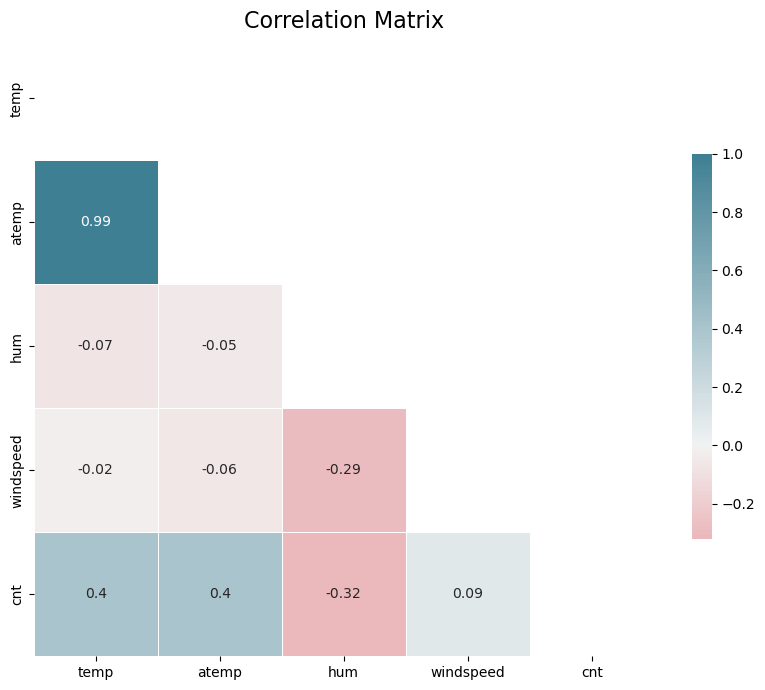

In [69]:
categorical_binary_cols = ['season','yr','hr','mnth','weekday','weathersit','workingday','holiday']
plot_correlation_heatmap(data,categorical_binary_cols)

# Show the plot
plt.show()

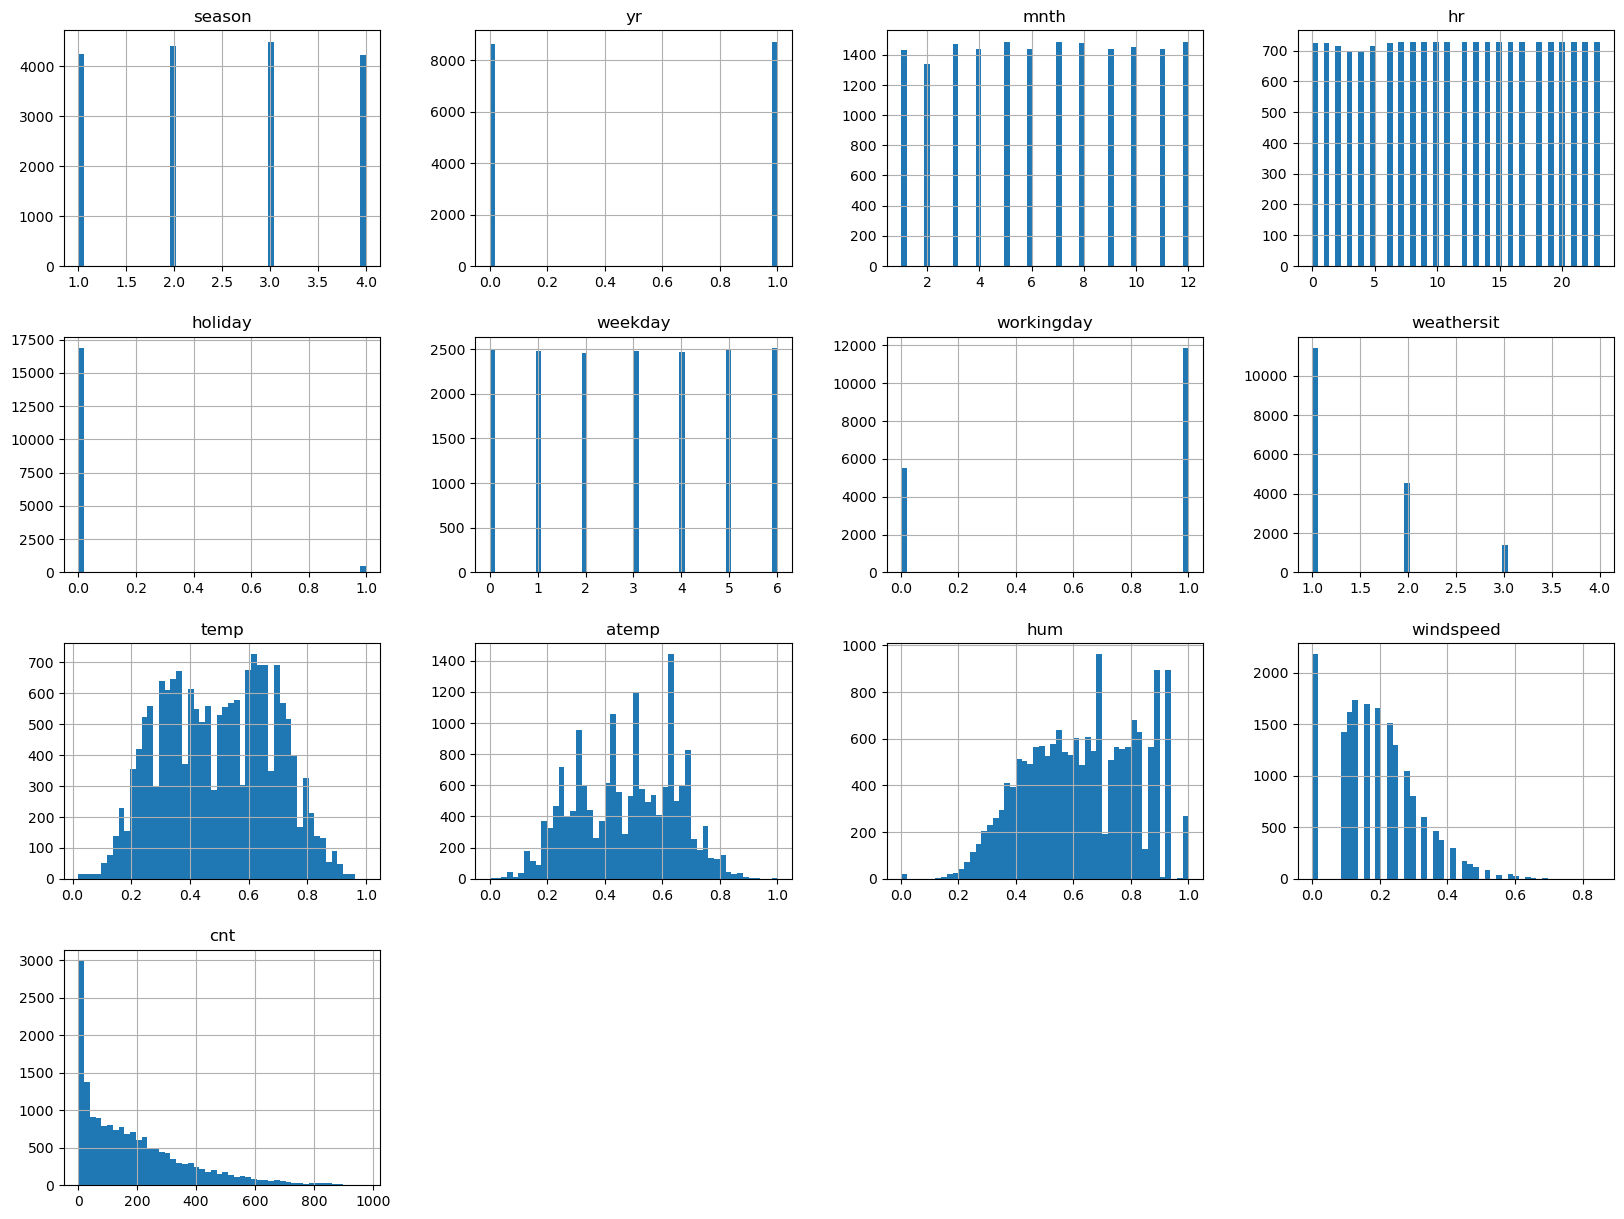

In [70]:
data.hist(bins=50, figsize=(20,15))
plt.show()

## Correlation conlusions
It seems that our target variable "cnt" is positively correlated with temperature (temp/atemp), windspeed and negatively correlated with humidity (hum). This is intuitive, as people opt to use bikes in better outdoor conditions.
temp and atemp are highly correlated. we will choose one further down, to see if there are any data anomalies to take into consideration.

Feature Selection
What we won't use as features:

* atemp (interchangeable with temp)

What we will use as features:
* season
* hr
* holiday
* weekday
* workingday
* weathersit
* temp
* hum
* windspeed
* yr
* mnth

Target variable:
* cnt

## Histogram analysis conclusions

* Our target variable 'cnt' seems to have an exponential distribution, meaning we have a lot of hours with very few rentals, and a few instances with a very high amount of rentals.

* Temperature (temp) looks like two overlapped normal distributions, which may be caused by the seasons fluctuations of temperatures across the year.

* Humidity (hum) seems to follow a normal distribution, with a strong skewness towards the left (we have a considerable number of extremely high humidity cases).



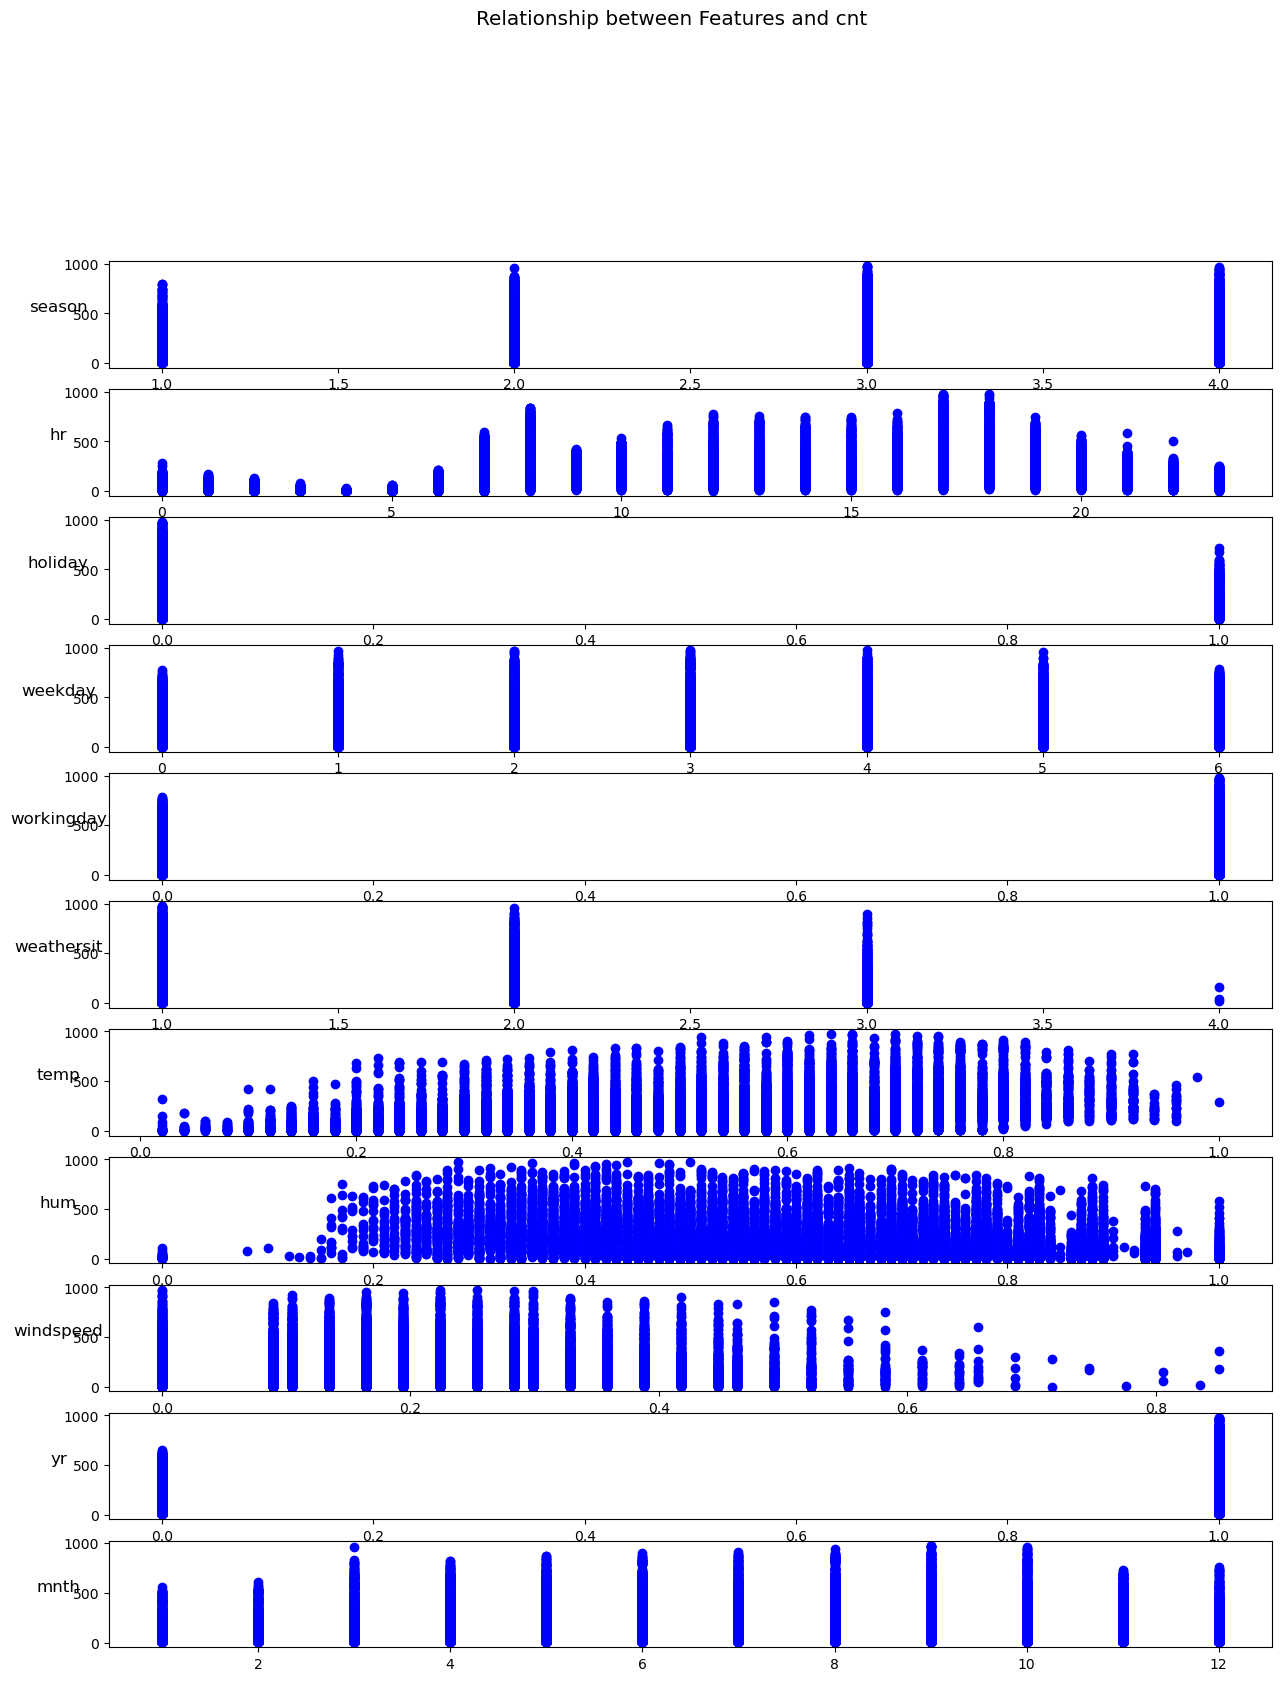

In [71]:
# Separating features from targets for relationship analysis
features = ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'yr', 'mnth']
target = 'cnt'  # Only using 'cnt' as the target variable

# Create a plot containing scatterplots between each feature and the target
figure, axes = plt.subplots(figsize=(15, 18), nrows=len(features), ncols=1)

for feat_num, feature in enumerate(features):
    axes[feat_num].scatter(data[feature], data[target], color='blue')  # Specify color parameter here
    axes[feat_num].set_ylabel(feature, rotation=0, size='large')

figure.suptitle(f"Relationship between Features and {target}", y=1.02, size='x-large')

plt.show()

## Observations:
* mnth plot shows that January had the least amount of bike shares whereas in summer season bike share was high
* weathersit plot shows that when weather was clear bike share was maximum, when misty, it was less, when light snow it was lesser and when heavy rain, it was least.
* workingday plot shows that on weekends, bike share was a bit less compared to weekdays.
* hr plot shows that ride share is high from 7 to 9 am then from 4 to 8pm which makes sense as 7 to 9am and 4 to 8pm are school/office going and leaving time respectively.
* temp plot shows that the higher the temperature, the higher the ride share.

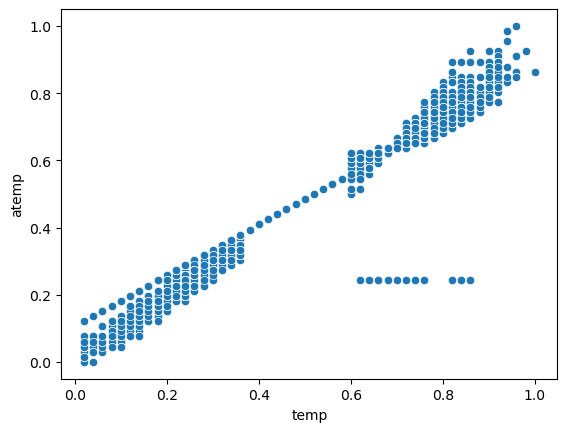

In [72]:
ax = sns.scatterplot(x="temp", y="atemp", data=data)

it seems we have some anomalous values - values where atemp seems to have a value of about 0.22 but temp has values between 0.6 and 0.9. We should remove these observations.

## Data Cleaning

In [91]:
temp_mask = (data['temp'] > 0.6) & (data['temp'] < 0.9)
atemp_mask = (data['atemp'] > 0.15) & (data['atemp'] < 0.3)
anomalous_df = data[temp_mask & atemp_mask]
anomalous_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
Datetime,,,,,,,,,,,,,
2012-08-17 00:00:00,3,1,8,0,0,5,1,1,0.68,0.2424,0.57,0.1642,88
2012-08-17 01:00:00,3,1,8,1,0,5,1,1,0.66,0.2424,0.65,0.1045,54
2012-08-17 02:00:00,3,1,8,2,0,5,1,1,0.66,0.2424,0.61,0.1343,19
2012-08-17 03:00:00,3,1,8,3,0,5,1,1,0.64,0.2424,0.65,0.1045,6
2012-08-17 04:00:00,3,1,8,4,0,5,1,1,0.64,0.2424,0.73,0.1642,9
2012-08-17 05:00:00,3,1,8,5,0,5,1,1,0.64,0.2424,0.73,0.1045,36
2012-08-17 06:00:00,3,1,8,6,0,5,1,1,0.62,0.2424,0.78,0.1343,157
2012-08-17 07:00:00,3,1,8,7,0,5,1,1,0.64,0.2424,0.73,0.1045,379
2012-08-17 08:00:00,3,1,8,8,0,5,1,1,0.68,0.2424,0.65,0.1343,668


In [92]:
clean_df = data[~(temp_mask & atemp_mask)]

## Data Pre-Processing

In [93]:
# one-hot encoding
categorical_features = ["season", "hr", "holiday", "weekday", "weathersit"]
for feature in categorical_features:
    clean_df = pd.get_dummies(clean_df, columns=[feature])  # One-hot encode

#lag-introduction as feature
lag_value = 20

clean_df[f'lag_{lag_value}'] = data["cnt"].shift(lag_value)

# Separate features and target variable
features = clean_df.drop(["cnt","atemp"], axis=1)
target = clean_df["cnt"] 

features,target

(                     yr  mnth  workingday  temp   hum  windspeed  season_1  \
 Datetime                                                                     
 2011-01-01 00:00:00   0     1           0  0.24  0.81     0.0000         1   
 2011-01-01 01:00:00   0     1           0  0.22  0.80     0.0000         1   
 2011-01-01 02:00:00   0     1           0  0.22  0.80     0.0000         1   
 2011-01-01 03:00:00   0     1           0  0.24  0.75     0.0000         1   
 2011-01-01 04:00:00   0     1           0  0.24  0.75     0.0000         1   
 ...                  ..   ...         ...   ...   ...        ...       ...   
 2012-12-31 19:00:00   1    12           1  0.26  0.60     0.1642         1   
 2012-12-31 20:00:00   1    12           1  0.26  0.60     0.1642         1   
 2012-12-31 21:00:00   1    12           1  0.26  0.60     0.1642         1   
 2012-12-31 22:00:00   1    12           1  0.26  0.56     0.1343         1   
 2012-12-31 23:00:00   1    12           1  0.26  0.

## XGBOOST Model Formulation and Prediction

In [94]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define XGBoost model
model = XGBRegressor()

# Perform GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Make predictions on test data using the best model
y_pred = best_model.predict(X_test)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  2.0min finished


Best hyperparameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


## Model Evaluation

In [95]:
# Evaluate model performance
rmse = mean_squared_error(y_test,y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mad = mean_absolute_error(y_test,y_pred)
rmse,r2,mad

(44.43475298012715, 0.9385280219251755, 28.111887663905488)

## Plots

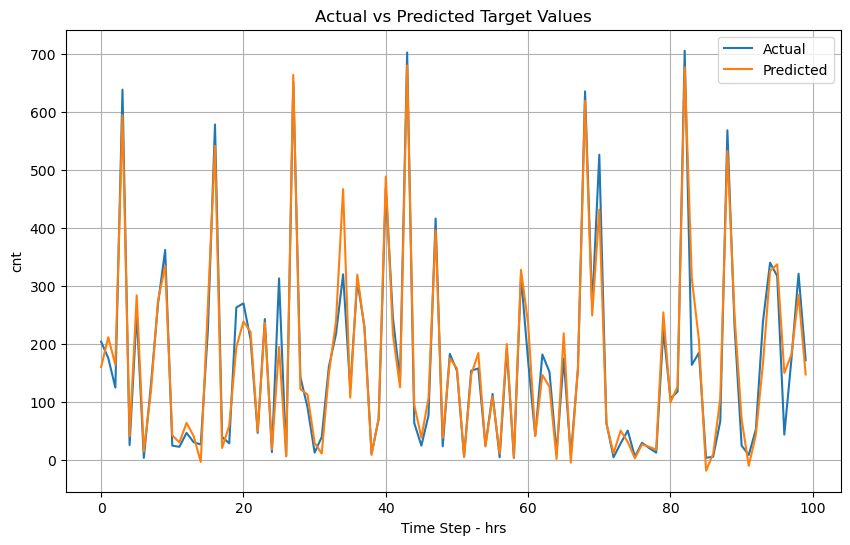

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(y_test)[500:600], label='Actual')
plt.plot(np.array(y_pred)[500:600], label='Predicted')
plt.xlabel('Time Step - hrs')
plt.ylabel('cnt')
plt.title('Actual vs Predicted Target Values')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# Print feature importances
print("Feature Importances:", best_model.feature_importances_)

Feature Importances: [0.02220275 0.00178596 0.03343355 0.01510757 0.01132407 0.00085164
 0.01533071 0.00097705 0.00169887 0.00930733 0.0165418  0.0212818
 0.06567408 0.11878728 0.12459935 0.11602389 0.02834676 0.01485214
 0.04177963 0.00613833 0.00347476 0.00535408 0.00282804 0.00195362
 0.0060333  0.00512655 0.02580107 0.12355297 0.05772053 0.03739331
 0.0170399  0.00903836 0.00458208 0.00484193 0.00206691 0.
 0.00179248 0.00120299 0.00087782 0.00086759 0.00160299 0.00257554
 0.00324116 0.00123971 0.00071936 0.00616466 0.         0.00686374]


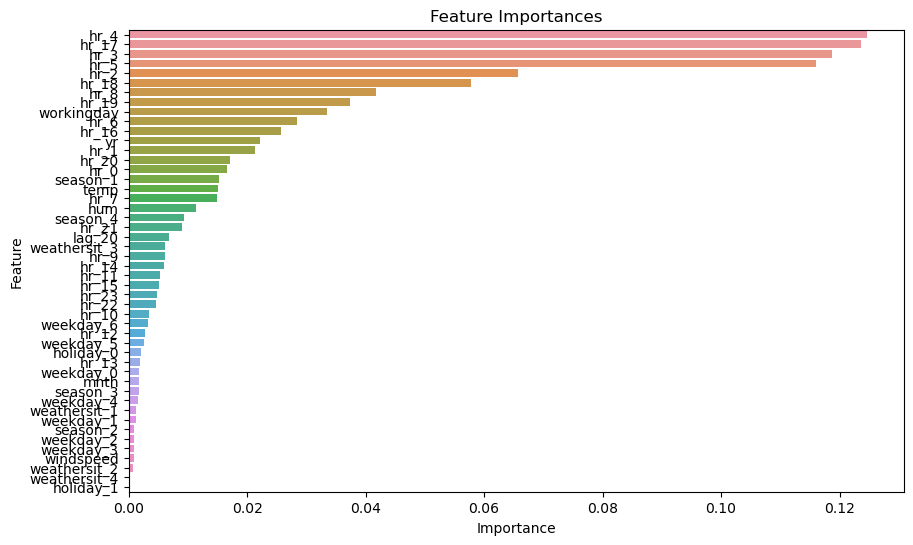

In [101]:
feature_importances = best_model.feature_importances_
feature_names = features.columns

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()